## Matrix Factorization
* Collaborative filtering 은 대표적인 memory based approach 이다. 추천이 필요할 때마다 데이터를 모두 메모리에 가지고 있으면서 계산을 하기 때문에 memory based 라 부른다.
* 이와 다른 방법론이 model-based approach 이고 이는 추천을 위한 모델을 구성한 후에 이 모델만 저장해 실제 추천을 할 때 이 모델을 사용해서 추천을 하는 방식을 말한다.
* 행렬 요인화 (Matrix Factorizaition ; MF) 는 대표적인 model-based approach 이고 deep-learning 을 활용한 방법 역시 model-based approach에 속한다.
* memory-based approach 는 대량의 데이터를 다뤄야 하는 상황에서는 원래 데이터를 충실하게 사용하는 장점에도 불구하고 계산 시간 및 비용이 너무 많이 든다는 단점이 있다.
* 대규모의 데이터를 다루는 domain에서 model-based approach는 모델을 학습 후 구축하고 나면 데이터를 통해 계산을 하지 않기 때문에 빠르게 반응할 수 있다. (하지만 모델을 구축하는 과정에서 많은 시간이 소요된다)
* 일반적으로 memory-based approach는 개별 사용자의 데이터에 집중하는 반면 model-based approach는 전체 사용자의 평가 패턴으로부터 모델을 구성하기 때문에 데이터가 가지는 weak signal을 더 잘 잡아내는 경향이 있다.

### MF의 방식과 원리
* MF는 평가 데이터 즉, user * item matrix를 2개의 행렬로 분해하는 방법이다. 2개의 행렬은 각각 user latent matrix와 item latent matrix가 된다.

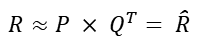

* 원래의 FULL Matrix는 평가되지 않은 data point가 포함되어 있는 상태인데 이를 사용자 잠재 요인을 담는 matrix와 item 잠재 요인을 담는 matrix로 쪼개어 분석하는 것이 MF의 방식이다.
* 각각은 (M x k) 와 (N x k)의 차원을 가지므로 두 행렬을 내적 연산을 하게 되면 (M x N) 행렬을 도출하게 된다. 이 행렬을 원래의 행렬과 가까운 값을 가지도록 하는 두 행렬을 구하게 되면 추천을 위한 모델이 된다. 여기서 k 가 user와 item을 설명하는 latent factor 의 차원 수가 되며 이것을 학습하는 방법으로 Stochastic Gradient Descent 를 활용할 수 있다.


### SGD를 활용한 MF의 학습
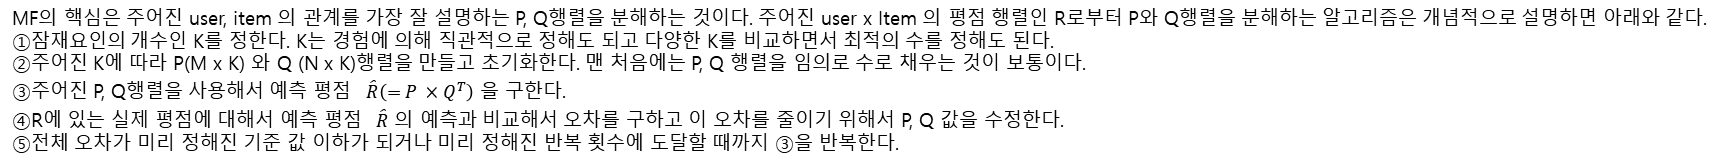


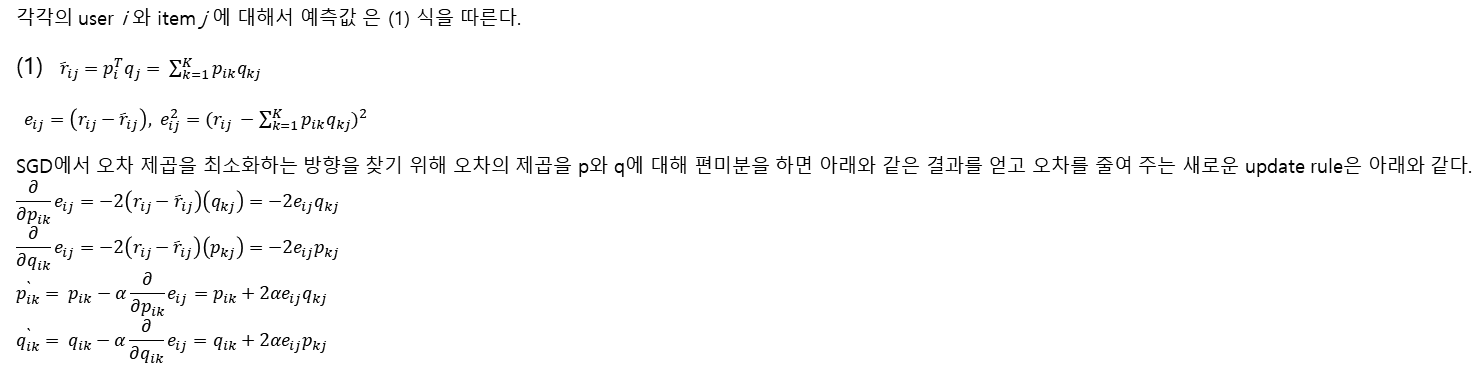

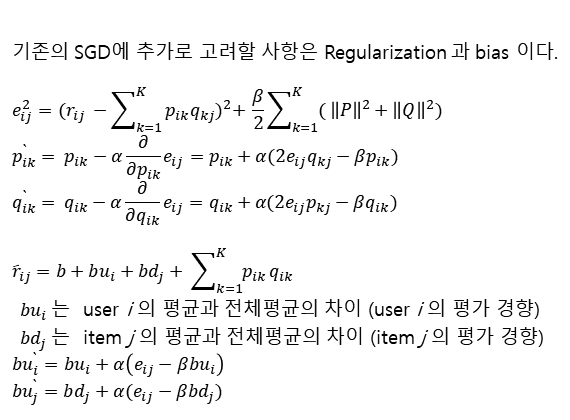

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_repo = '/content/drive/MyDrive/recommender_system/practice/'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [ ]:
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_repo+'u.data', sep='\t', names = r_cols, encoding='latin-1')
ratings = ratings[['user_id','movie_id','rating']]

In [ ]:
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations , verbose = True):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose
        
    def rmse(self):
        xs, ys = self.R.nonzero() #평점이 0이 아닌 data point의 index
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x,y) # 행렬 분해를 이용한 예측값
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    def train(self):
        # initializing user-feature and moive-feature matrix
        self.P = np.random.normal(scale=1./self.K, size = (self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size = (self.num_items, self.K))

        #initializing bias term
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        #List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i,j, self.R[i,j]) for i,j in zip(rows, columns)]

        # stochastic gradient descent algorithm
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose:
                if (i+1) %10 ==0:
                    print("Iteration: %d ; Train RMSE = %.4f" % (i+1, rmse))
        return training_process

    def get_prediction(self, i,j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction

    def sgd(self):
        for i,j,r in self.samples:
            prediction = self.get_prediction(i,j)
            e = (r-prediction)
            self.b_u[i] += self.alpha * (e- self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e- self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

In [ ]:
R_temp = ratings.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
mf = MF(R_temp, K=30, alpha=.001, beta = .02, iterations = 100, verbose = True)
train_process = mf.train()

Iteration: 10 ; Train RMSE = 0.9585
Iteration: 20 ; Train RMSE = 0.9373
Iteration: 30 ; Train RMSE = 0.9280
Iteration: 40 ; Train RMSE = 0.9225
Iteration: 50 ; Train RMSE = 0.9183
Iteration: 60 ; Train RMSE = 0.9144
Iteration: 70 ; Train RMSE = 0.9098
Iteration: 80 ; Train RMSE = 0.9036
Iteration: 90 ; Train RMSE = 0.8946
Iteration: 100 ; Train RMSE = 0.8825


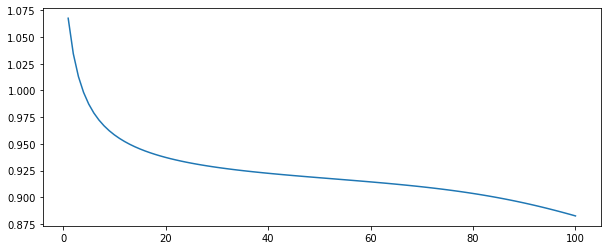

In [ ]:
plt.figure(figsize=(10,4))
x = np.array(train_process)[:,0]
y = np.array(train_process)[:,1]
plt.plot(x, y)

In [ ]:
class MF_test(MF):
    def __init__(self, ratings, K, alpha, beta, iterations, verbose = True):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

        item_id_index = []
        index_item_id = []
        for i , one_id in enumerate(ratings):
            item_id_index.append([one_id, i]) # item의 id와 index를 저장해 id로 item을 mapping 할 수 있도록 함
            index_item_id.append([i, one_id]) # 반대로 item으로 id를 mapping할 수 있도록 함

        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        user_id_index = []
        index_user_id = []
        for i,one_id in enumerate(ratings.T): 
            user_id_index.append([one_id, i]) # user id 로 index 를 mapping 할 수 있도록 함
            index_user_id.append([i, one_id]) # index 로 user id를 mapping 할 수 있도록 함
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i,0]]
            y = self.item_id_index[ratings_test.iloc[i,1]]
            z = ratings_test.iloc[i,2]
            test_set.append([x,y,z])
            self.R[x,y] = 0
        self.test_set = test_set
        return test_set

    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error / len(self.test_set))

    def test(self):
        self.P = np.random.normal(scale=1./self.K, size = (self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size = (self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        rows, columns = self.R.nonzero()
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows,columns)]
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1,rmse1, rmse2))
            if self.verbose:
                if (i+1) %50 ==0:
                    print("Iteration: %d  : Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process
    
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    def full_predictions(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)

In [ ]:
# train / test split
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_repo+'u.data', sep='\t', names = r_cols, encoding='latin-1')
ratings = ratings[['user_id','movie_id','rating']]

from sklearn.utils import shuffle
TRAIN_SIZE = .9
ratings = shuffle(ratings, random_state = 42)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [ ]:
ratings_train.head()

,user_id,movie_id,rating
75721,877,381,4
80184,815,602,3
19864,94,431,4
76699,416,875,2
92991,500,182,2


In [ ]:
ratings_test.head()

,user_id,movie_id,rating
44990,655,271,3
9425,178,83,4
68711,873,294,4
26425,10,116,4
11294,325,305,2


In [ ]:
R_temp = ratings.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
mf = MF_test(R_temp, K=30, alpha=.001, beta=.02, iterations=200, verbose = True)
test_set = mf.set_test(ratings_test)
results = mf.test()

Iteration: 10  : Train RMSE = 0.9609 ; Test RMSE = 0.9824
Iteration: 20  : Train RMSE = 0.9386 ; Test RMSE = 0.9631
Iteration: 30  : Train RMSE = 0.9288 ; Test RMSE = 0.9548
Iteration: 40  : Train RMSE = 0.9229 ; Test RMSE = 0.9503
Iteration: 50  : Train RMSE = 0.9187 ; Test RMSE = 0.9475
Iteration: 60  : Train RMSE = 0.9150 ; Test RMSE = 0.9455
Iteration: 70  : Train RMSE = 0.9112 ; Test RMSE = 0.9438
Iteration: 80  : Train RMSE = 0.9066 ; Test RMSE = 0.9420
Iteration: 90  : Train RMSE = 0.9003 ; Test RMSE = 0.9396
Iteration: 100  : Train RMSE = 0.8915 ; Test RMSE = 0.9362
Iteration: 110  : Train RMSE = 0.8800 ; Test RMSE = 0.9320
Iteration: 120  : Train RMSE = 0.8661 ; Test RMSE = 0.9275
Iteration: 130  : Train RMSE = 0.8506 ; Test RMSE = 0.9234
Iteration: 140  : Train RMSE = 0.8342 ; Test RMSE = 0.9200
Iteration: 150  : Train RMSE = 0.8169 ; Test RMSE = 0.9174
Iteration: 160  : Train RMSE = 0.7990 ; Test RMSE = 0.9157
Iteration: 170  : Train RMSE = 0.7806 ; Test RMSE = 0.9146
Iterat

In [ ]:
print(mf.full_predictions())
print(mf.get_one_prediction(1,2))

[[3.76725209 2.98140709 3.36293981 ... 3.30233842 3.4602693  3.36892096]
 [3.89693944 3.12484299 3.04209024 ... 3.34767151 3.53293945 3.48464737]
 [3.2515739  2.84160206 2.53409492 ... 2.73958385 2.97018119 2.89415828]
 ...
 [4.38064495 3.61868591 3.34843677 ... 3.58754228 3.7852005  3.69919074]
 [4.54289282 3.77776585 3.46509403 ... 3.61113107 3.90170879 3.81401601]
 [4.32424902 3.86732258 2.82504532 ... 3.2948291  3.41413722 3.35349438]]
2.9814070945631608


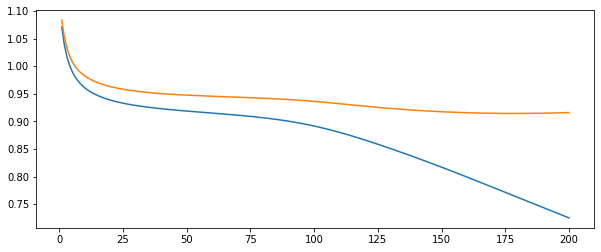

In [ ]:
plt.figure(figsize=(10,4))
x = np.array(results)[:,0]
y = np.array(results)[:,1]
z = np.array(results)[:,2]
plt.plot(x, y)
plt.plot(x, z)

### Exercise 1
* 위의 결과를 도출하기 까지의 과정에서 문제가 있다. 어떤 원인으로 발생한 문제인가?
* train test set을 구성하는 방법 중 위에서 활용한 shuffle이 아닌 train test split 함수를 이용해 분리하고 결과를 비교해보기. 
* RMSE의 차이가 난다면 그 이유는?

In [ ]:
def train_test_rating(rating_matrix,random_seed = 42):
    x= rating_matrix.copy()
    y= rating_matrix['user_id']
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = .25, stratify = y, random_state = random_seed)
    cold_start = X_test.loc[~X_test['movie_id'].isin(X_train['movie_id'].unique()), 'movie_id']
    X_train = X_train.append(X_test.loc[X_test['movie_id'].isin(cold_start.values), :])
    X_test = X_test.drop(cold_start.index)
    return X_train, X_test

In [ ]:
from sklearn.model_selection import train_test_split

r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_repo+'u.data', sep='\t', names = r_cols, encoding='latin-1')
ratings = ratings[['user_id','movie_id','rating']]

In [ ]:
x= ratings.copy()
y= ratings['user_id']
# 무작위로 unique user를 균일한 size 로 추출하게 됨 -> user 의 특정 column set 이 test set로 구성됨
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = .25, stratify = y, random_state = 42) 

In [ ]:
X_train.head()

,user_id,movie_id,rating
94871,889,684,2
45252,135,203,4
90833,774,674,2
1570,161,98,4
46935,506,578,3


In [ ]:
X_test.head()

,user_id,movie_id,rating
33745,237,489,4
93837,535,156,2
19779,176,303,3
76325,83,756,4
10309,232,204,4


In [ ]:
cold_start = X_test.loc[~X_test['movie_id'].isin(X_train['movie_id'].unique()), 'movie_id']
len(cold_start)

42

In [ ]:
print(X_train.shape, X_test.shape)
X_train = X_train.append(X_test.loc[X_test['movie_id'].isin(cold_start.values), :])
X_test = X_test.drop(cold_start.index)
print(X_train.shape, X_test.shape)

(75000, 3) (25000, 3)
(75042, 3) (24958, 3)


In [ ]:
R_temp = X_train.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
mf = MF_test(R_temp, K=30, alpha=.001, beta=.02, iterations=200, verbose = True)
test_set = mf.set_test(X_test)
results = mf.test()

Iteration: 10  : Train RMSE = 0.9682 ; Test RMSE = 0.9786
Iteration: 20  : Train RMSE = 0.9435 ; Test RMSE = 0.9573
Iteration: 30  : Train RMSE = 0.9322 ; Test RMSE = 0.9485
Iteration: 40  : Train RMSE = 0.9254 ; Test RMSE = 0.9440
Iteration: 50  : Train RMSE = 0.9205 ; Test RMSE = 0.9413
Iteration: 60  : Train RMSE = 0.9165 ; Test RMSE = 0.9395
Iteration: 70  : Train RMSE = 0.9127 ; Test RMSE = 0.9382
Iteration: 80  : Train RMSE = 0.9086 ; Test RMSE = 0.9370
Iteration: 90  : Train RMSE = 0.9036 ; Test RMSE = 0.9357
Iteration: 100  : Train RMSE = 0.8971 ; Test RMSE = 0.9340
Iteration: 110  : Train RMSE = 0.8887 ; Test RMSE = 0.9318
Iteration: 120  : Train RMSE = 0.8777 ; Test RMSE = 0.9289
Iteration: 130  : Train RMSE = 0.8643 ; Test RMSE = 0.9256
Iteration: 140  : Train RMSE = 0.8490 ; Test RMSE = 0.9224
Iteration: 150  : Train RMSE = 0.8322 ; Test RMSE = 0.9198
Iteration: 160  : Train RMSE = 0.8145 ; Test RMSE = 0.9179
Iteration: 170  : Train RMSE = 0.7962 ; Test RMSE = 0.9167
Iterat

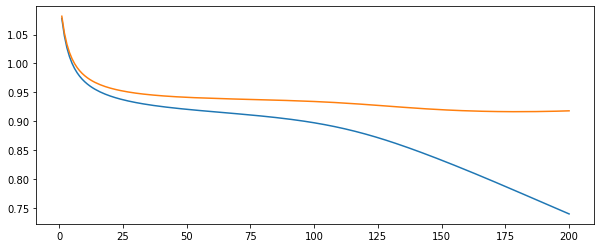

In [ ]:
plt.figure(figsize=(10,4))
x = np.array(results)[:,0]
y = np.array(results)[:,1]
z = np.array(results)[:,2]
plt.plot(x, y)
plt.plot(x, z)

### Hyper parameter tuning for MF
* latent factor의 수 인 K 와 학습 iteration 수에 따라 성능이 달라질 수 있다.
* Overfitting issue
* 여러 parameter searching 방법 (ex. random search, grid search)이 활용될 수 있다.

In [ ]:
# Finding optimal K
# 넓은 범위에서 K를 바꿔가면서 성능 계산 (10단위)
# 전 단계에서 최적인 K에서 다시 범위를 좁게 두어 성능 계산 (1단위)

results = []
index = []
for k in range(50, 261, 10):
    print(' K = ', k)
    R_temp = X_train.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
    mf = MF_test(R_temp, K=k, alpha=.001, beta=.02, iterations=300, verbose = True)
    test_set = mf.set_test(X_test)
    result = mf.test()
    print()
    index.append(k)
    results.append(result)

In [ ]:
# K값에 따라 iteration 중 RMSE가 최소가 되는 i 를 추출
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

In [ ]:
summary #평균 243회 iteration

[[50, 204, 0.9110125016048173],
 [60, 216, 0.9080251568462643],
 [70, 220, 0.9083863558101047],
 [80, 221, 0.9067445188839476],
 [90, 229, 0.9052400671007925],
 [100, 236, 0.9059155921709267],
 [110, 237, 0.9048416667551519],
 [120, 241, 0.9048932496974224],
 [130, 244, 0.9050964542845114],
 [140, 245, 0.9052732598122439],
 [150, 245, 0.9041441266107885],
 [160, 249, 0.9044142301150906],
 [170, 250, 0.9041906570443387],
 [180, 254, 0.9028258111808531],
 [190, 251, 0.903585662806799],
 [200, 253, 0.9038943214176435],
 [210, 257, 0.9041405756541063],
 [220, 259, 0.9030235539652249],
 [230, 260, 0.9030789592494853],
 [240, 260, 0.9031830693049936],
 [250, 261, 0.9025949463513147],
 [260, 264, 0.9028223626183924]]

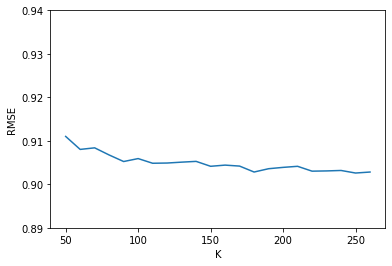

In [ ]:
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

### Exercise
* K를 200대에서 일정한 값으로 바꿔가면서 좁은 범위 내에서 최적의 K를 찾아보기. 각 K별로 train set, test set 의 random seed를 5번 바꿔서 다르게 구성해 RMSE를 계산하고 그 평균값을 계산
* 위의 최적의 K값을 기준으로 alpha와 beta 값을 아래의 범위 내에서 조정해가며 최적값을 탐색해보기 (alpha : 0.0007 ~ 0.0014 / beta : 0.01  ~0.07)
* 탐색된 parameter들을 기준으로 MF model을 학습시켜 test set의 첫 10개 data에 대한 예측값과 실제값을 비교해보기

In [ ]:
# Finding optimal K
# 넓은 범위에서 K를 바꿔가면서 성능 계산 (10단위)
# 전 단계에서 최적인 K에서 다시 범위를 좁게 두어 성능 계산 (1단위)

results = []
index = []

for k in range(170, 191, 1):
    print(' K = ', k)
    rmse_list = []
    for i in range(5):
        seed_num = np.random.randint(1e+3)
        X_train_r, X_test_r = train_test_rating(ratings, random_seed = seed_num)

        R_temp = X_train_r.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
        mf = MF_test(R_temp, K=k, alpha=.001, beta=.02, iterations=250, verbose = True)
        test_set = mf.set_test(X_test_r)
        result = mf.test()
        rmse_list.append(result)
        print()
    rmse_avg = [np.array(rmse_list)[:,0].mean(), np.array(rmse_list)[:,1].mean()] #train rmse, validation rmse
    index.append(k)
    results.append(rmse_avg)

 K =  170
Iteration: 50  : Train RMSE = 0.9231 ; Test RMSE = 0.9424
Iteration: 100  : Train RMSE = 0.9122 ; Test RMSE = 0.9378
Iteration: 150  : Train RMSE = 0.8850 ; Test RMSE = 0.9285
Iteration: 200  : Train RMSE = 0.8126 ; Test RMSE = 0.9120
Iteration: 250  : Train RMSE = 0.7063 ; Test RMSE = 0.9046

Iteration: 50  : Train RMSE = 0.9230 ; Test RMSE = 0.9441
Iteration: 100  : Train RMSE = 0.9121 ; Test RMSE = 0.9391
Iteration: 150  : Train RMSE = 0.8851 ; Test RMSE = 0.9289
Iteration: 200  : Train RMSE = 0.8136 ; Test RMSE = 0.9109
Iteration: 250  : Train RMSE = 0.7054 ; Test RMSE = 0.9030

Iteration: 50  : Train RMSE = 0.9220 ; Test RMSE = 0.9475
Iteration: 100  : Train RMSE = 0.9112 ; Test RMSE = 0.9426
Iteration: 150  : Train RMSE = 0.8833 ; Test RMSE = 0.9328
Iteration: 200  : Train RMSE = 0.8111 ; Test RMSE = 0.9172
Iteration: 250  : Train RMSE = 0.7049 ; Test RMSE = 0.9104

Iteration: 50  : Train RMSE = 0.9232 ; Test RMSE = 0.9421
Iteration: 100  : Train RMSE = 0.9122 ; Test RM

In [ ]:
# Finding optimal alpha
# 넓은 범위에서 K를 바꿔가면서 성능 계산 (10단위)
# 전 단계에서 최적인 K에서 다시 범위를 좁게 두어 성능 계산 (1단위)

results_alpha = []
index_alpha = []
for a in range(0.0007, 0.0014, 0.0001):
    print(' alpha = ', a)
    R_temp = X_train.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
    mf = MF_test(R_temp, K=235, alpha=a, beta=.02, iterations=250, verbose = True)
    test_set = mf.set_test(X_test)
    result = mf.test()
    print()
    index_alpha.append(a)
    results_alpha.append(result)

In [ ]:
# Finding optimal beta
# 넓은 범위에서 K를 바꿔가면서 성능 계산 (10단위)
# 전 단계에서 최적인 K에서 다시 범위를 좁게 두어 성능 계산 (1단위)

results_beta = []
index_beta = []
for b in range(0.0007, 0.0014, 0.0001):
    print(' alpha = ', a)
    R_temp = X_train.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
    mf = MF_test(R_temp, K=235, alpha=0.0012, beta=b, iterations=250, verbose = True)
    test_set = mf.set_test(X_test)
    result = mf.test()
    print()
    index_beta.append(k)
    results_beta.append(result)

### MF 와 SVD
* MF와 SVD 모두 데이터분석 및 기계학습에 널리 사용되고 유사한 점이 있지만 명백히 다른 기법이다.
* SVD는 데이터를 3개의 행렬로 분해해서 이를 학습시키고 3개의 행렬로 원래의 행렬을 재현하는 기법이다. 그에 비해 MF에서는 원래 데이터(M X N) 을 P(M X K) 와 Q(N X K) 2개의 행렬로 분해하는 점에서 차이가 있다.
* SVD는 원래 행렬을 분해해서 3개의 행렬로 만든 다음에 이를 사용해 우너래 행렬을 재현하는 데에는 매우 뛰어나지만, 원래 행렬에 없는 값을 예측하는 데에는 문제가 있다. (원래 행렬에 null을 허용하지 않는데 이를 0으로 채워 넣은 경우 이를 하나의 값으로 인식해 0이었던 원소는 모두 0에 가깝게 재현됨)
